In [ ]:
%pip install torch_tb_profiler einops

# Vectorization

We'll increasingly focus on technical details of attention. In this practical, you will learn:
- details of multiheaded attention
- how to evaluate performance of PyTorch modules

In the end, you'll be tasked to implement a version of Mixture of Experts layer from the paper Switch Transformer.

For simplicity sake, we omit some implementation details of self-attention layer.

Let's look at the following implementation of a very simple Multi-headed self attention(MHA).

In [ ]:
from torch import nn
import math
import torch
from transformers import PretrainedConfig

# A huggingface transformer config is a dictionary that contains all the hyperparameters of the model.
# Very often, hyperparameters are shared between different models and different architectures.
# See initializer here: https://github.com/huggingface/transformers/blob/cbe58b4269457a6ca66a556224b23f9ef246f905/src/transformers/configuration_utils.py#L265
# It is convenient for the modules to accept config as an argument and parse the hyperparameters from it.

config = PretrainedConfig(
    hidden_size=768,
    num_attention_heads=12,
)

class SingleHeadSelfAttention(nn.Module):
    def __init__(self, config: PretrainedConfig):
        super(SingleHeadSelfAttention, self).__init__()

        self.hidden_size = config.hidden_size
        num_attention_heads = config.num_attention_heads
        self.head_size = self.hidden_size // num_attention_heads

        self.query_proj = nn.Linear(self.hidden_size, self.head_size, bias=False)
        self.key_proj = nn.Linear(self.hidden_size, self.head_size, bias=False)
        self.value_proj = nn.Linear(self.hidden_size, self.head_size, bias=False)

    def forward(self, hidden_states):
        queries = self.query_proj(hidden_states)
        keys = self.key_proj(hidden_states)
        values = self.value_proj(hidden_states)

        attention_scores = torch.matmul(queries, keys.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.hidden_size)

        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        contextualized_layer = torch.matmul(attention_probs, values)

        return contextualized_layer

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, config: PretrainedConfig):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_attention_heads = config.num_attention_heads
        self.hidden_size = config.hidden_size
        self.head_size = self.hidden_size // self.num_attention_heads
        self.heads = nn.ModuleList([
            SingleHeadSelfAttention(config)
            for _ in range(self.num_attention_heads)
        ])

    def forward(self, embeddings):
        # embeddings: [batch_size, seq_length, hidden_size]
        outputs = []
        for i, head in enumerate(self.heads):
            # head_output: [batch_size, seq_length, head_size]
            head_output = head(embeddings)
            # outputs: List[[batch_size, seq_length, head_size]]
            outputs.append(head_output)
        # in the end: outputs: [heads, batch_size, seq_length, head_size]
        # now we need to convert it to [batch_size, seq_length, heads, head_size]

        # outputs: [batch_size, seq_length, heads, head_size]
        outputs = torch.stack(outputs, dim=2)

        # outputs: [batch_size, seq_length, heads * head_size]
        outputs = outputs.view(embeddings.size(0), embeddings.size(1), self.hidden_size)
        return outputs


Obviously, this isn't a very efficient implementation. Generally, a for loop within a forward method might be a hint that something can be streamlined there.

First, let's try to evaluate performance of what we currently have by using PyTorch Profiler to measure the time and memory consumption.

As a quick warmup, let's see how the model fares in GPU vs CPU scenario.

### GPU

In [ ]:
config = PretrainedConfig(
    hidden_size=768,
    num_attention_heads=12,
)

attention = MultiHeadSelfAttention(config).cuda()
batches = [
    torch.randn(32, 128, 768).cuda()
    for _ in range(100)
]

from datetime import datetime

with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=1, warmup=4, active=50, repeat=5),
    on_trace_ready=torch.profiler.tensorboard_trace_handler("./log/naive/gpu" + datetime.now().strftime("%Y%m%d-%H%M%S")),
    record_shapes=True,
    profile_memory=True,
) as prof:
    for batch in batches:
        attention(batch)
        torch.cuda.synchronize() # wait for CPU & GPU to finish running the code
        prof.step()


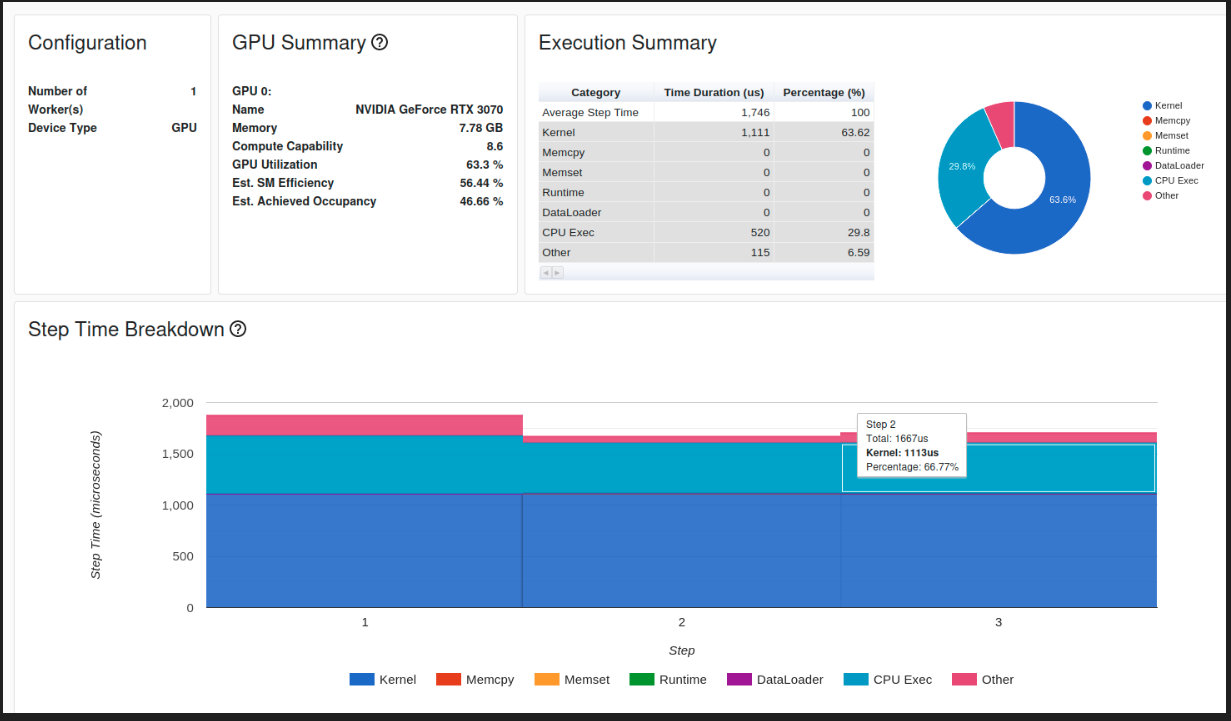

### CPU

In [ ]:
# literally the same but on CPU

config = PretrainedConfig(
    hidden_size=768,
    num_attention_heads=12,
)

attention = MultiHeadSelfAttention(config).cpu()
batches = [
    torch.randn(32, 128, 768).cpu()
    for _ in range(100)
]

from datetime import datetime

with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=1, warmup=4, active=50, repeat=5),
    on_trace_ready=torch.profiler.tensorboard_trace_handler("./log/naive/cpu" + datetime.now().strftime("%Y%m%d-%H%M%S")),
    record_shapes=True,
    profile_memory=True,
) as prof:
    for batch in batches:
        attention(batch)
        torch.cuda.synchronize() # wait for CPU & GPU to finish running the code
        prof.step()

# you can read individual logs using https://ui.perfetto.dev/
# you can use SQL queries like: SELECT SUM(dur) / 1e9 FROM slice WHERE name = 'aten::matmul'

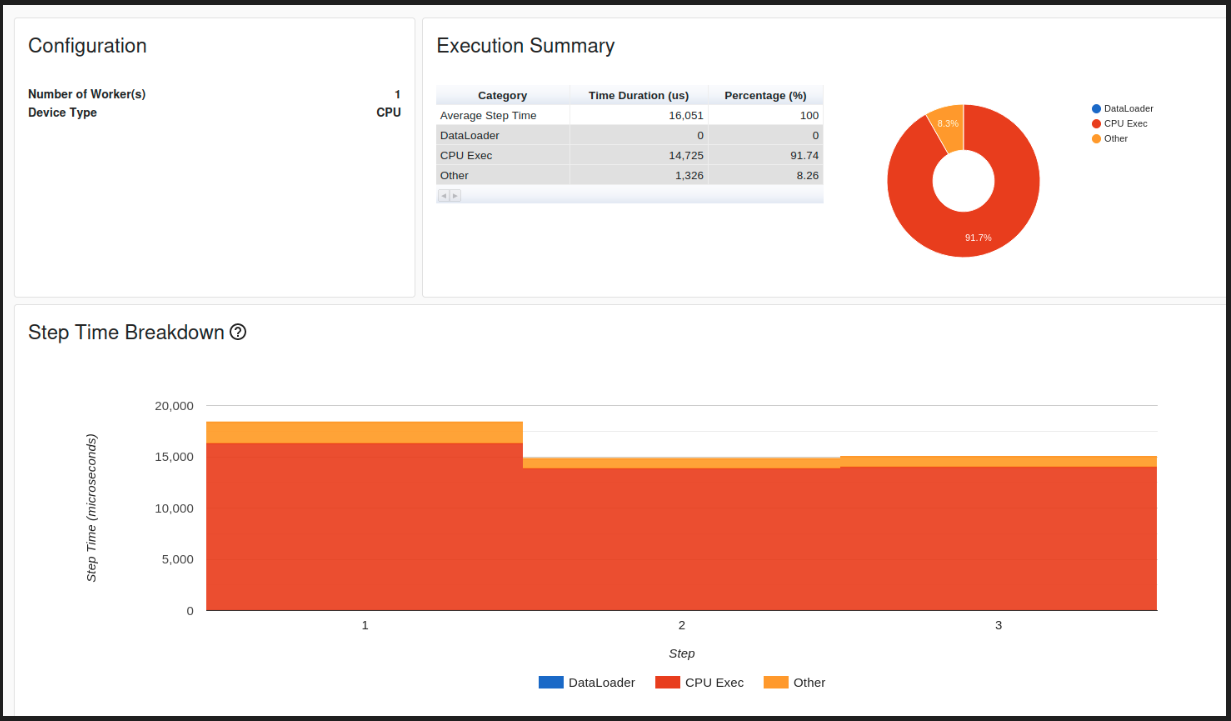

In [ ]:
%load_ext tensorboard
%tensorboard --logdir log

The difference between CPU and GPU execution is substantial. Now, let's try to increase vectorization by making our implementation more streamlined.

In [ ]:
# if you are unsure how torch operations work, the simplest way is to check some example input
a = torch.arange(20).reshape(1, 5, 4)
print(a)
a = a.reshape(1, 5, 2, 2)
print(a)

In [ ]:
class MultiHeadSelfAttentionMk2(nn.Module):
    def __init__(self, config: PretrainedConfig):
        super(MultiHeadSelfAttentionMk2, self).__init__()
        self.num_attention_heads = config.num_attention_heads
        self.hidden_size = config.hidden_size
        self.head_size = self.hidden_size // self.num_attention_heads

        # Let's take a query projection as an example
        # We used num_attention_heads different query projections before
        # Therefore, we used a function of type: hidden_size -> num_attention_heads x head_size
        # instead of using num_attention_heads linear layers on the same input, we can use a single linear layer

        self.query_proj = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.key_proj = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.value_proj = nn.Linear(self.hidden_size, self.hidden_size, bias=False)

    def forward(self, embeddings):
        batch_size, seq_length, hidden_size = embeddings.size()
        # queries, keys, values: [batch_size, seq_length, hidden_size]
        queries = self.query_proj(embeddings)
        keys = self.key_proj(embeddings)
        values = self.value_proj(embeddings)

        # now we need to split the queries, keys, and values into num_attention_heads parts
        # queries, keys, values: [batch_size, seq_length, num_attention_heads, head_size]
        queries = queries.view(batch_size, seq_length, self.num_attention_heads, self.head_size)
        keys = keys.view(batch_size, seq_length, self.num_attention_heads, self.head_size)
        values = values.view(batch_size, seq_length, self.num_attention_heads, self.head_size)

        # now we need to make it so that seq_length x head_size are the last dimensions
        # queries, keys, values: [batch_size, num_attention_heads, seq_length, head_size]
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        # now for each head, we need to compute the attention scores
        # attention_scores: [batch_size, num_attention_heads, seq_length, seq_length]
        attention_scores = torch.matmul(queries, keys.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(hidden_size)

        # attention_probs: [batch_size, num_attention_heads, seq_length, seq_length]
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # contextualized_layer: [batch_size, num_attention_heads, seq_length, head_size]
        contextualized_layer = torch.matmul(attention_probs, values)

        # now we need to rearrange dimensions so that they can be concatenated
        # rearranged_contextualized_layer: [batch_size, seq_length, num_attention_heads, head_size]
        rearranged_contextualized_layer = contextualized_layer.transpose(1, 2)

        # now we can concatenate the heads
        # outputs: [batch_size, seq_length, hidden_size]
        outputs = rearranged_contextualized_layer.contiguous().view(batch_size, seq_length, hidden_size)

        return outputs

attention = MultiHeadSelfAttentionMk2(config).cuda()
batches = [
    torch.randn(32, 128, 768).cuda()
    for _ in range(100)
]

from datetime import datetime

with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=1, warmup=4, active=50, repeat=5),
    on_trace_ready=torch.profiler.tensorboard_trace_handler("./log/optimized/gpu" + datetime.now().strftime("%Y%m%d-%H%M%S")),
    record_shapes=True,
    profile_memory=True,
) as prof:
    for batch in batches:
        attention(batch)
        torch.cuda.synchronize() # wait for CPU & GPU to finish running the code
        prof.step()

In [ ]:
# just to be sure that the code is correct, we'll compare the outputs of the two implementations
# we need to set the weights of the mk2 model to be the same as the weights of the naive model
attention_naive = MultiHeadSelfAttention(config)
attention_mk2 = MultiHeadSelfAttentionMk2(config)

print(attention_mk2.query_proj.weight.shape, attention_naive.heads[0].query_proj.weight.shape)

In [ ]:
batch_sz = 32
seq_len = 128
hidden_sz = config.hidden_size
num_heads = config.num_attention_heads
head_sz = hidden_sz // num_heads

batch = torch.randn(batch_sz, seq_len, hidden_sz)

# let's set appropriate weights for the mk2 model
attention_mk2.query_proj.weight.data = torch.cat([
    attention_naive.heads[i].query_proj.weight.data
    for i in range(num_heads)
], dim=0)

with torch.no_grad():
    # query_result_naive: [num_attention_heads, batch_size, seq_length, head_size]
    query_result_naive = torch.stack([
        attention_naive.heads[i].query_proj(batch)
        for i in range(attention_naive.num_attention_heads)
    ])
    # query_result_naive: [batch_size, seq_length, num_attention_heads, head_size]
    query_result_naive = query_result_naive.permute(1, 2, 0, 3)

    # query_result_mk2: [batch_size, seq_length, hidden_size]
    query_result_mk2 = attention_mk2.query_proj(batch)

    # we need to rearrange the dimensions to [batch_size, seq_length, num_attention_heads, head_size]
    # query_result_mk2: [batch_size, seq_length, num_attention_heads, head_size]
    query_result_mk2 = query_result_mk2.view(batch_sz, seq_len, num_heads, head_sz)

    assert torch.allclose(query_result_naive, query_result_mk2, atol=1e-4)

In [ ]:
# now that we know we are correct for queries, let's do the same for keys and values

attention_mk2.query_proj.weight.data = torch.cat([
    attention_naive.heads[i].query_proj.weight.data
    for i in range(num_heads)
], dim=0)

attention_mk2.key_proj.weight.data = torch.cat([
    attention_naive.heads[i].key_proj.weight.data
    for i in range(num_heads)
], dim=0)

attention_mk2.value_proj.weight.data = torch.cat([
    attention_naive.heads[i].value_proj.weight.data
    for i in range(num_heads)
], dim=0)

attention_naive.eval()
attention_mk2.eval()

with torch.no_grad():
    result_naive = attention_naive(batch)
    result_mk2 = attention_mk2(batch)

    assert torch.allclose(result_naive, result_mk2, atol=1e-4)

Einops notation is able to express many basic PyTorch operations in one instruction.

In [ ]:
from einops import rearrange

class MultiHeadSelfAttentionMk3(nn.Module):
    def __init__(self, config: PretrainedConfig):
        super(MultiHeadSelfAttentionMk3, self).__init__()
        self.num_attention_heads = config.num_attention_heads
        self.hidden_size = config.hidden_size
        self.head_size = self.hidden_size // self.num_attention_heads
        self.num_attention_heads = config.num_attention_heads

        # we merge the query, key, and value projections into a single linear layer
        self.qkv = nn.Linear(self.hidden_size, 3 * self.hidden_size, bias=False)

    def forward(self, embeddings):
        batch_size, seq_length, hidden_size = embeddings.size()

        # result: [batch_size, seq_length, 3 * hidden_size]
        result = self.qkv(embeddings)
        # 3 * hidden_size needs to be split in q, k, v
        # with einops.rearrange, we can do this easily:
        # result = rearrange(result, 'b s (qkv hidden) -> b s qkv hidden', qkv=3)
        # then hidden_size needs to be split in num_attention_heads x head_size
        # result = rearrange(result, 'b s (qkv nah hdsz) -> b s nah hdsz qkv', nah=self.num_attention_heads, qkv=3)
        # for the purpose of computing attention scores we need seq_length x head_size as the last two dimensions
        # result = rearrange(result, 'b s (qkv nah hdsz) -> b qkv nah s hdsz', nah=self.num_attention_heads, qkv=3)
        # actually it would be great if we could split qkv into different entities
        # result = rearrange(result, 'b s (qkv nah hdsz) -> qkv b nah s hdsz', nah=self.num_attention_heads, qkv=3)
        q, k, v = rearrange(result, 'b s (qkv nah hdsz) -> qkv b nah s hdsz', nah=self.num_attention_heads, qkv=3).unbind(0)

        # attention_scores: [batch_size, num_attention_heads, seq_length, seq_length]
        attention_scores = torch.matmul(q, k.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(hidden_size)

        # attention_probs: [batch_size, num_attention_heads, seq_length, seq_length]
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # contextualized_layer: [batch_size, num_attention_heads, seq_length, head_size]
        contextualized_layer = torch.matmul(attention_probs, v)

        # now, we need to get the heads together
        outputs = rearrange(contextualized_layer, 'b nah s hdsz -> b s (nah hdsz)')
        return outputs

In [ ]:
attention_mk2 = MultiHeadSelfAttentionMk2(config)
attention_mk3 = MultiHeadSelfAttentionMk3(config)

# a linear layer is basically a matrix multiplication
# in Mk2 we had 3 linear layers, in Mk3 we have a single linear layer

attention_mk3.qkv.weight.data = torch.cat([
    attention_mk2.query_proj.weight,
    attention_mk2.key_proj.weight,
    attention_mk2.value_proj.weight
])

attention_mk2.eval()
attention_mk3.eval()

with torch.no_grad():
    result_mk2 = attention_mk2(batch)
    result_mk3 = attention_mk3(batch)
    assert torch.allclose(result_mk2, result_mk3, atol=1e-4)

In [ ]:
attention_mk3 = MultiHeadSelfAttentionMk3(config).cuda()

attention_mk3.cuda()

with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(skip_first=10, wait=1, warmup=5, active=50, repeat=5),
    on_trace_ready=torch.profiler.tensorboard_trace_handler("./log/einops/gpu" + datetime.now().strftime("%Y%m%d-%H%M%S")),
    record_shapes=True,
    profile_memory=True,
) as prof:
    for batch in batches:
        attention_mk3(batch)
        torch.cuda.synchronize() # wait for CPU & GPU to finish running the code
        prof.step()